In [1]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo
import serial
%matplotlib inline

import Encoding
import Transmission
import RiFiJPEG
import pyaudio
import operator

import Queue 
import threading
import time
import ax25

In [2]:
IMG_DIR = 'Images/'
IMG_NAME = 'calBlue.tiff'

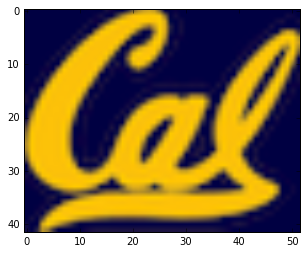

In [3]:
img = ndimage.imread(IMG_DIR + IMG_NAME)
plt.imshow(img)
plt.show()

In [152]:
tsize, ssize, Y, Cb, Cr, Rlim, Glim, Blim = RiFiJPEG.RiFi_preprocess(img, 2)
header = (img.shape[0], img.shape[1], tsize[0], tsize[1], ssize[0], ssize[1], Rlim[1], Glim[1], Blim[1])
### TRANSMIT: img.shape[:2], tsize, ssize, Y, Cb, Cr ###

imgRecon = RiFiJPEG.RiFi_postprocess(Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]), 2, Rlim, Glim, Blim)

In [5]:
reload(Encoding)
reload(Transmission)

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

eY = Encoding.encode(Y, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
a = len(eY)
# _ = Transmission.testTransmit(e)

eCb = Encoding.encode(Cb, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
b = len(eCb)
# Transmission.testTransmit(e)

eCr = Encoding.encode(Cr, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
c = len(eCr)
# Transmission.testTransmit(e)

print (a+b+c)//8
print img.shape[0]*img.shape[1]*3

0 Microsoft Sound Mapper - Input
1 Microphone (Realtek High Defini
2 Microphone (5- USB PnP Sound De
3 Microsoft Sound Mapper - Output
4 Speakers (Realtek High Definiti
5 Speakers (5- USB PnP Sound Devi
6 Realtek Digital Output (Realtek
1220
6552


In [6]:
dusb_in = 2
dusb_out = 5
d_in = 1
d_out = 4

In [7]:
reload(Transmission)
reload(Encoding)

bits = Transmission.bitStreamify(range(9), Y, Cb, Cr)
test = Transmission.packetize(bits)
# print Transmission.packetize(eY)
# test = Transmission.NRZ2NRZI(test)
NRZI = bitarray.bitarray()
for packet in test:
    sig = Transmission.afsk1200(packet, 48e3)
    analog = Transmission.nc_afsk1200Demod(sig, TBW=2.0)
    signed = np.sign(analog)
    idx = Transmission.PLL(analog, fs=48e3, baud=2400).astype(int)
    samples = bitarray.bitarray([bit >= 0 for bit in np.array(analog)[idx]])
#     bits = Transmission.NRZI2NRZ(samples)

    NRZI += samples
#     plt.figure(figsize=(20,5))
#     plt.plot(analog[-2000:])
#     plt.stem(idx[-35:]-idx[-35]+620, analog[idx[-35:]])

# print reduce(operator.add, test)
# print NRZI[:100]
# print Transmission.NRZI2NRZ(NRZI)[:100]
# # print Transmission.packetize(eY)
# # print Transmission.findPackets(Transmission.NRZI2NRZ(test))
# print Transmission.NRZI2NRZ(NRZI)
# print len(Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)))
test = reduce(operator.add, Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)))
with open("eY.txt", "w") as text_file:
    for t in Transmission.justPacketize(bits):
        text_file.write(t.to01())
        text_file.write("\n")
with open("test.txt", "w") as text_file:
#     text_file.write(Transmission.NRZI2NRZ(NRZI).to01())
    for t in Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)):
        text_file.write(t.to01())
        text_file.write("\n")
size, dY, dCb, dCr = Transmission.deStreamify(test)
# print test[:,0]
# print Y[:,0]
print size
print np.sum(dY != Y)
print np.sum(dCb != Cb)
print np.sum(dCr != Cr)
# print test.to01() == eY.to01()

[0, 1, 2, 3, 4, 5, 6, 7, 8]
0
0
0


Closed  record thread
[42, 52, 48, 56, 24, 32, 255, 210, 76]
0
0
0


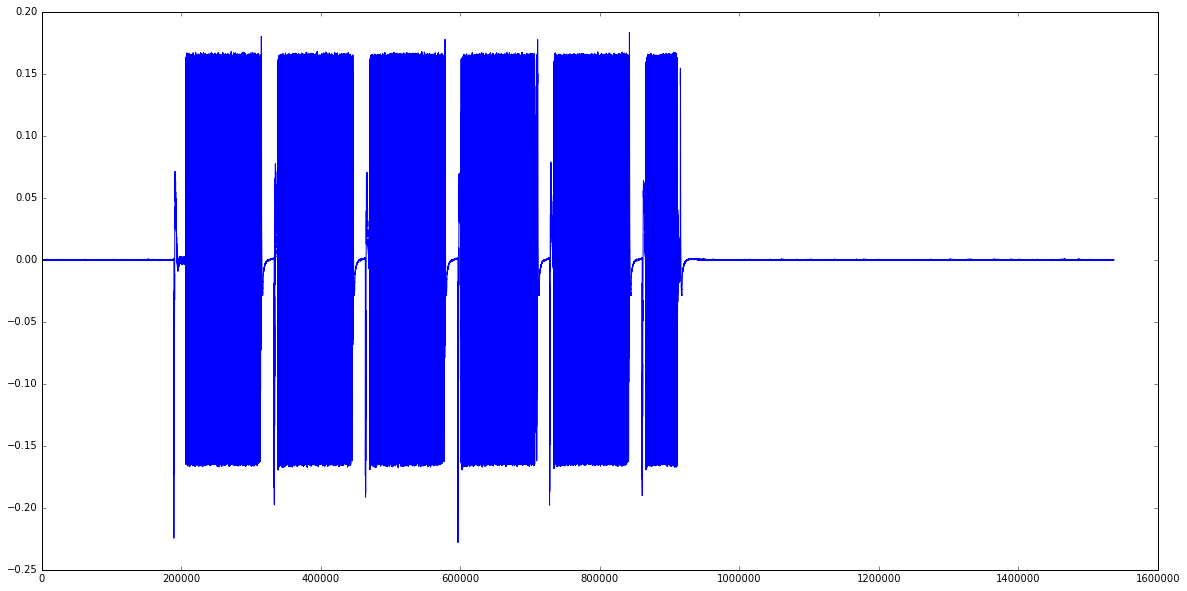

In [155]:
reload(Encoding)
reload(Transmission)

s = serial.Serial(port='COM3')
s.setDTR(0)

Qin = Queue.Queue()
cQin = Queue.Queue()
Qout = Queue.Queue()
cQout = Queue.Queue()

p = pyaudio.PyAudio()

fs_usb = 48e3

t_rec = threading.Thread(target = Transmission.record_audio,   args = (Qin, cQin, p, fs_usb, dusb_in, 512))
t_rec.start()
time.sleep(1)

# toSend = [Transmission.afsk1200(packet, 48e3) for packet in Transmission.packetize(Transmission.bitStreamify(range(9), Y, Cb, Cr))]
# for sig in toSend:
#     Qout.put("KEYON")
# #     Qout.put(Transmission.afsk1200(bitarray.bitarray("01"*10)))
#     Qout.put(sig)
#     Qout.put("KEYOFF")
#     Qout.put(np.zeros(fs_usb//10))    
# Qout.put("EOT")

# Transmission.play_audio(Qout, cQout, p, fs_usb, dusb_out, s,0.2)

try:
    while True :
        time.sleep(1)
except:
    pass       


time.sleep(1)
cQin.put('EOT')
time.sleep(1) # give time for the thread to get killed


p.terminate()
s.close()

recorded = []
while not (Qin.empty()):
    recorded.append(Qin.get())
    
# NRZI = bitarray.bitarray()
# for packet in test:
#     sig = Transmission.afsk1200(packet, 48e3)
#     analog = Transmission.nc_afsk1200Demod(sig, TBW=2.0)
#     idx = Transmission.PLL(analog, fs=48e3).astype(int)
#     samples = bitarray.bitarray([bit >= 0 for bit in np.array(analog)[idx]])

#     NRZI += samples

fs = 48e3
data = np.array(recorded).flatten()

demod = Transmission.nc_afsk1200Demod(data, fs)
idx = Transmission.PLL(demod, fs=fs, baud=1200).astype(int)
samples = bitarray.bitarray([bit >= 0 for bit in np.array(demod)[idx]])
bits = Transmission.NRZI2NRZ(samples)
packets = Transmission.findPackets(bits)

with open("eY.txt", "w") as text_file:
    for t in Transmission.justPacketize(Transmission.bitStreamify(header, Y, Cb, Cr)):
        text_file.write(t.to01())
        text_file.write("\n")
with open("test.txt", "w") as text_file:
    for t in packets:
        text_file.write(t.to01())
        text_file.write("\n")
with open("test2.txt", "w") as text_file:
    text_file.write(bits.to01())       
plt.figure(figsize=(20,10))
x=np.where(data>np.max(data)*.5)[0][0]
plt.plot(data)
test = reduce(operator.add, packets)
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)
# print test[:,0]
# print Y[:,0]
# print np.sum(test != Y)
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)

# print np.sum(test != Y)
# print bits[:100]
# print reduce(operator.add, Transmission.packetize(eY))[:100]

size, dY, dCb, dCr = Transmission.deStreamify(test)
# print test[:,0]
# print Y[:,0]
print size
print np.sum(dY != Y)
print np.sum(dCb != Cb)
print np.sum(dCr != Cr)



TypeError: reduce() of empty sequence with no initial value

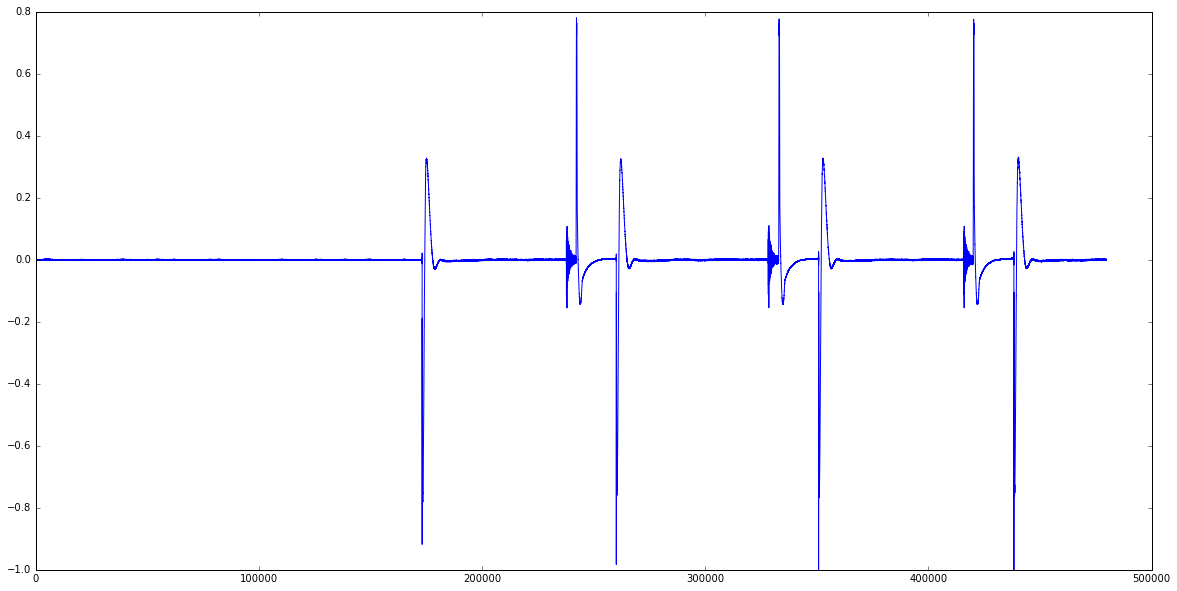

In [94]:
# NRZI = bitarray.bitarray()
# for packet in test:
#     sig = Transmission.afsk1200(packet, 48e3)
#     analog = Transmission.nc_afsk1200Demod(sig, TBW=2.0)
#     idx = Transmission.PLL(analog, fs=48e3).astype(int)
#     samples = bitarray.bitarray([bit >= 0 for bit in np.array(analog)[idx]])

#     NRZI += samples

fs = 48e3
data = np.array(recorded).flatten()

demod = Transmission.nc_afsk1200Demod(data, fs)
idx = Transmission.PLL(demod, fs=fs, baud=1200).astype(int)
samples = bitarray.bitarray([bit >= 0 for bit in np.array(demod)[idx]])
bits = Transmission.NRZI2NRZ(samples)
packets = Transmission.findPackets(bits)

with open("eY.txt", "w") as text_file:
    for t in Transmission.justPacketize(Transmission.bitStreamify(range(9), Y, Cb, Cr)):
        text_file.write(t.to01())
        text_file.write("\n")
with open("test.txt", "w") as text_file:
    for t in packets:
        text_file.write(t.to01())
        text_file.write("\n")
with open("test2.txt", "w") as text_file:
    text_file.write(bits.to01())       
plt.figure(figsize=(20,10))
x=np.where(data>np.max(data)*.5)[0][0]
plt.plot(data)
test = reduce(operator.add, packets)
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)
# print test[:,0]
# print Y[:,0]
# print np.sum(test != Y)
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)

# print np.sum(test != Y)
# print bits[:100]
# print reduce(operator.add, Transmission.packetize(eY))[:100]

size, dY, dCb, dCr = Transmission.deStreamify(test)
# print test[:,0]
# print Y[:,0]
print size
print np.sum(dY != Y)
print np.sum(dCb != Cb)
print np.sum(dCr != Cr)



In [ ]:

imgRecon = RiFiJPEG.RiFi_postprocess(Y, Cb, Cr, tsize, ssize, osize, 2, Rlim, Glim, Blim)

In [131]:
print bitarray.bitarray(ax25.bit_stuff(bitarray.bitarray("1010110101111101001101101100100001001010010011001111001010001111110111010010000111111001010000011110000000111011001011110010010010011111111101100001011110111111101010110111110100101010110111001101011100100100110000110011110111010110010010000101011000000110110110101101000101001000110001110101001110000111100110110000011110000011101110001000110010101001111011001000001100000011100000110101001011101001011100000000100010100000111100110100100011111001111001101110011100111101110001000110001111101110000011111100011111101111000111110111101010100111101010111101110000010010111010110110111010100111100001000000000111011111110111011000111111011101000001111111110111010001110011100011110101110001010110010101000001000001001001011100010010000010001110001100011001001001111011100111101000000000001110101011001100011111010000011111101010011110000001110011010110111010101110100100110110111010101010000101100100100100011101100111011011100000000100000100001010001100111000111111100001010111101111100011101011110011111110001101010101101011101110110000100000100001000100000010010001000101111111001101100110100100000010000000101100010010010000010001111111000100110001000111011011101111100011000111011110101101001110011010001000111110010011000101011010010000111111001010101011111000010001110110000111010101001000010101000111111011110001101100111111110111100110111000010100011101110010010010010011110110101011000100110101001010011001010110100100010110000010001111100010001010110111000110110001010000001110100110111011000110000110001111111111000000010001111100101110011111010111100110101110100101100011000000000100011100")))

bitarray('101011010111110010011011011001000010010100100110011110010100011111010111010010000111110100101000001111000000011101100101111001001001001111101111011000010111101111101101010110111110010010101011011100110101110010010011000011001111011101011001001000010101100000011011011010110100010100100011000111010100111000011110011011000001111000001110111000100011001010100111101100100000110000001110000011010100101110100101110000000010001010000011110011010010001111100011110011011100111001111011100010001100011111001110000011111010001111101011110001111100111101010100111101010111101110000010010111010110110111010100111100001000000000111011111011011101100011111010111010000011111011110111010001110011100011110101110001010110010101000001000001001001011100010010000010001110001100011001001001111011100111101000000000001110101011001100011111001000001111101010100111100000011100110101101110101011101001001101101110101010100001011001001001000111011001110110111000000001000001000010100011001110001111101100001010